# Deep Learning - Exercise 4

This lecture is about advanced topics of the CNN such as transfer learning and
1D convolutions for time-series processing.

We will use CIFAR-10 dataset again and
[FordA](https://www.timeseriesclassification.com/description.php?Dataset=FordA)
for time-series classification task.

**Core Concepts**

- 🧠 Transfer learning techniques in CNNs
- 📈 1D Convolutions for time-series processing
- 📊 CIFAR-10 dataset utilization
- ⏱️ FordA dataset for time-series classification tasks


[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_04.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_04.ipynb)

##### Remember to set **GPU** runtime in Colab!


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore", category=UserWarning, module="keras")
warnings.filterwarnings("ignore", message="Unable to register cuDNN factory")
warnings.filterwarnings("ignore", message="Unable to register cuBLAS factory")

In [3]:

import pandas as pd
import matplotlib.pyplot as plt  # plotting
import matplotlib.image as mpimg  # images
import seaborn as sns  # plotting
import numpy as np  # numpy
import tensorflow as tf
import tensorflow.keras as keras
import requests

from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7, EfficientNetB4

from sklearn.model_selection import train_test_split  # split for validation sets
from sklearn.preprocessing import normalize  # normalization of the matrix
from scipy.signal import convolve2d  # convolutionof the 2D signals
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from PIL import Image
from io import BytesIO
from skimage.transform import resize

tf.version.VERSION

2025-03-15 13:53:14.349238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742043194.366414   38450 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742043194.371092   38450 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.18.0'

In [4]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()


def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i][0]])
    plt.show()


def compute_metrics(y_true, y_pred, show_confusion_matrix=False):
    print(f'\tAccuracy: {accuracy_score(y_true, y_pred) * 100:8.2f}%')
    if (show_confusion_matrix):
        print('\tConfusion matrix:\n', confusion_matrix(y_true, y_pred))

# 🔎 What is _transfer learning_ about? 🔎

- Transfer learning consists of taking features learned on one problem, and
  leveraging them on a new, similar problem.

  - For instance, features from a model that has learned to identify cars may be
    useful to kick-start a model meant to identify trucks.
    - 🔎 Do you know any famous CNN models?

- Transfer learning is usually done for tasks where your dataset has too little
  data to train a full-scale model from scratch.
  - 🔎 How do we benefit from it?

## 📌 Usual pipeline

1. Take layers from a previously trained model.

2. Freeze them, so you avoid destroying any of the information they contain
   during future training rounds.

3. Add some new, trainable layers, on top of the frozen layers.

   - 💡 They will learn how to turn the features extracted by pre-trained layers
     into predictions on a new dataset.

4. Train the new layers using your dataset.

- 💡 Optional step: Fine-tuning (= unfreezing the entire model you obtained
  above, or part of it), and re-training it on the new data with a very **low**
  learning rate.
  - This can potentially achieve meaningful improvements, by incrementally
    adapting the pretrained features to the new data.
  - 🔎 Why do we use **low** learning rate?


# 🚀 Let's start!

## Import dataset **CIFAR10** again

- I think (or hope 😀) that you remember most of these detailes from the
  previous lecture 🙂
  - The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different
    classes.
  - The 10 different classes represent airplanes, cars, birds, cats, deer, dogs,
    frogs, horses, ships, and trucks.
  - There are 6,000 images of each class.

## We will resize the images into (224, 224) shape because we will use ResNet50 later and we will also one-hot encode our labels

- 💡 If you do not encode the labels you will run into shape mismatch error
  which is hard to debug - trust me, I've been there 🙂


In [5]:
# cifar is the basic dataset for image classifaction
dataset = tf.keras.datasets.cifar10
img_size = 224
subset = 1000
test_size = 0.2

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_y = tf.keras.utils.to_categorical(train_y[:subset], class_count)
test_y = tf.keras.utils.to_categorical(test_y[:subset], class_count)

train_x_resized = tf.image.resize(train_x[:subset], [img_size, img_size], )
test_x_resized = tf.image.resize(test_x[:subset], [img_size, img_size])

I0000 00:00:1742043198.884462   38450 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


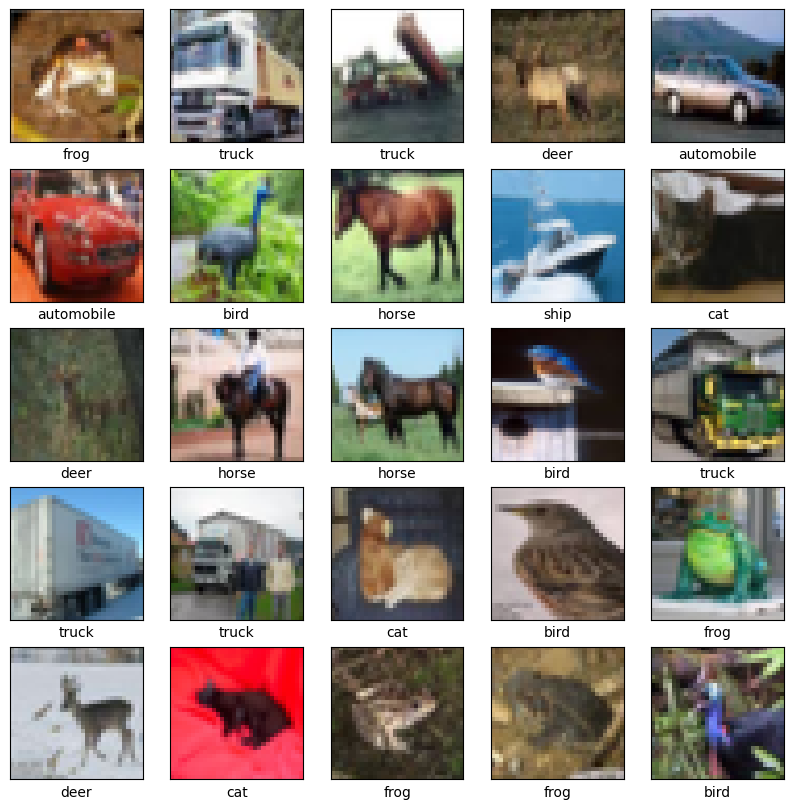

In [6]:
show_example(train_x, np.argmax(train_y, axis=1).reshape(-1, 1), class_names)

# Instantiate a `ResNet50` model with pre-trained weights.

- 🔎 What the **include_top** do?
- What means **weights='imagenet'** parameter?
  - 🔎 Do we need it?
  - 🔎 What happens if we use random weights?


In [7]:
base_model = ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_size, img_size, 3),
    include_top=False)  # Do not include the ImageNet classifier part at the top.

## 📌 IMPORTANT: Freeze the base model 📌

- We don't want to train the encoder path of model yet


In [8]:
base_model.trainable = False

# ⚡ Create a model input and output layers and interconnect all the parts together

- 💡 We make sure that the base_model is running in inference mode here, by
  passing `training=False`.

## 📌 Notes about BatchNormalization layer

- Many image models contain **BatchNormalization** layers.
- Here are a few things to keep in mind:
  - BatchNormalization contains 2 non-trainable weights that get updated during
    training.
    - These are the variables **tracking the mean and variance of the inputs**.
- 💡 When you **unfreeze** a model that contains BatchNormalization layers in
  order to do **fine-tuning**, you should **keep the BatchNormalization layers
  in inference mode by passing training=False** when calling the base model.

  - **Otherwise the updates applied to the non-trainable weights will suddenly
    destroy what the model has learned.**

- 🔎 What the **GlobalAveragePooling2D** layer does?
  - After convolutional operations, _tf.keras.layers.Flatten_ will reshape a
    tensor into (n_samples, height*width*channels), for example turning (16, 28,
    28, 3) into (16, 2352)
  - _GlobalAveragePooling_ layer is an alternative to this because it averages
    all the values according to the last axis.
    - This means that the resulting shape will be (n_samples, last_axis).
    - 💡 For instance, if your last convolutional layer had 64 filters, it would
      turn (16, 7, 7, 64) into (16, 64)


# 📌 Make sure that you call the `preprocess_input` function

- Each Keras Application expects a specific kind of input preprocessing.
- For ResNet, call `tf.keras.applications.resnet.preprocess_input` on your
  inputs before passing them to the model.
  - 💡 It will convert the input images from RGB to BGR, then will zero-center
    each color channel with respect to the ImageNet dataset, without scaling.


In [9]:
inputs = keras.Input(shape=(img_size, img_size, 3), dtype=tf.uint8)
x = keras.ops.cast(inputs, dtype=tf.float32)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(class_count, activation='softmax')(x)
model = keras.Model(inputs, outputs)

## Compile the model and check number of parameters

- Why do we have only **20,490** trainable parameters?
- Why do we use `CategoricalAccuracy` and `CategoricalCrossentropy`?


In [10]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ cast[0][0]        │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ cast[0][0]        │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     20,490 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

![Meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_tf_01.png?raw=true)


## 💡 Always check if all the shapes match the pre-defined ranges!

- Otherwise you will run into shape missmatch issue in the training loop and it
  is harder to debug than the C++ templates 😅


In [11]:
train_x_resized.shape, train_y.shape

(TensorShape([1000, 224, 224, 3]), (1000, 10))

In [12]:
test_x_resized.shape, test_y.shape

(TensorShape([1000, 224, 224, 3]), (1000, 10))

## 🚀 Fit the model


In [13]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10


I0000 00:00:1742043208.579785   38603 service.cc:148] XLA service 0x7f03ec0036b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742043208.579820   38603 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
I0000 00:00:1742043209.736531   38603 cuda_dnn.cc:529] Loaded cuDNN version 90501


 1/25 ━━━━━━━━━━━━━━━━━━━━ 5:01 13s/step - categorical_accuracy: 0.0312 - loss: 3.1437

I0000 00:00:1742043216.122045   38603 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - categorical_accuracy: 0.2395 - loss: 2.3321 - val_categorical_accuracy: 0.6400 - val_loss: 0.9298
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - categorical_accuracy: 0.7624 - loss: 0.7075 - val_categorical_accuracy: 0.8150 - val_loss: 0.5973
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - categorical_accuracy: 0.8715 - loss: 0.4194 - val_categorical_accuracy: 0.8300 - val_loss: 0.5236
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - categorical_accuracy: 0.9204 - loss: 0.3062 - val_categorical_accuracy: 0.8400 - val_loss: 0.4960
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - categorical_accuracy: 0.9559 - loss: 0.2223 - val_categorical_accuracy: 0.8450 - val_loss: 0.4762
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - categorical_accuracy: 0.9829 - loss: 0.1526 - val_categorical_accuracy: 0.8400 - val_loss: 0.4451
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - categorical_accuracy: 0.9882 - loss: 0.1359 

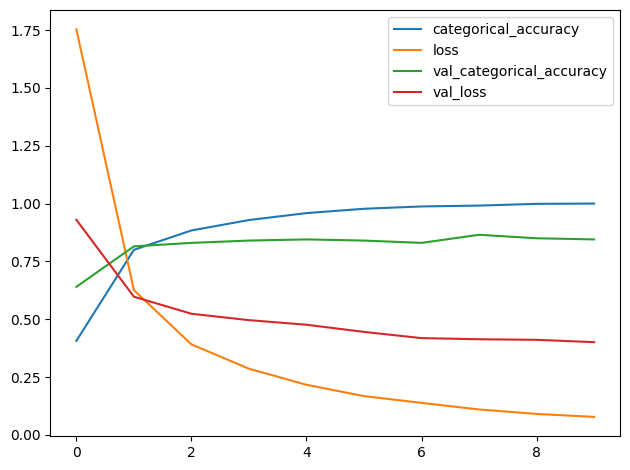

In [14]:
history = model.fit(
    train_x_resized,
    train_y,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[model_checkpoint_callback])

show_history(history)

# Load best setup
model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x_resized, test_y)
print('Test accuracy: ', test_acc)

# 🚀 Fine-tuning

- Once your model has converged on the new data, you can try to unfreeze all or
  part of the base model and retrain the whole model end-to-end with a very low
  learning rate.
  - 💡 It could also potentially lead to quick overfitting -- keep that in mind.
- It is critical to only do this step **after the model with frozen layers has
  been trained to convergence**.
  - 💡 If you mix randomly-initialized trainable layers with trainable layers
    that hold pre-trained features the randomly-initialized layers will cause
    very large gradient updates during training,
  - This will **destroy your pre-trained features**.

### It's also critical to use a _very low learning rate_ at this stage,

- You are training a much larger model than in the first round of training, on a
  dataset that is typically very small.
  - 💡 As a result, you are at **risk of overfitting** very quickly if you apply
    large weight updates.


## Unfreeze the base model


In [15]:
base_model.trainable = True

## 💡 Recompile your model after you make any changes

- The `trainable` attribute of any inner layer is taken into account after
  re-compilation

- Calling `compile()` on a model is meant to "freeze" the behavior of that
  model.
  - This implies that the trainable attribute values at the time the model is
    compiled should be preserved throughout the lifetime of that model, until
    compile is called again.
  - Hence, if you change any trainable value, make sure to call `compile()`
    again on your model for your changes to be taken into account.


In [16]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ cast[0][0]        │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ cast[0][0]        │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     20,490 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 481ms/step - categorical_accuracy: 0.5996 - loss: 1.1051 - val_categorical_accuracy: 0.8300 - val_loss: 0.4713
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - categorical_accuracy: 0.8884 - loss: 0.3914 - val_categorical_accuracy: 0.7700 - val_loss: 0.5834
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - categorical_accuracy: 0.9700 - loss: 0.1964 - val_categorical_accuracy: 0.7700 - val_loss: 0.6037
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - categorical_accuracy: 0.9989 - loss: 0.1035 - val_categorical_accuracy: 0.7600 - val_loss: 0.6101
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - categorical_accuracy: 1.0000 - loss: 0.0784 - val_categorical_accuracy: 0.7650 - val_loss: 0.6026
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - categorical_accuracy: 0.9985 - loss: 0.0657 - val_categorical_accuracy: 0.7600 - val_loss: 0.6051
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - categorical_accuracy: 0.9990 - lo

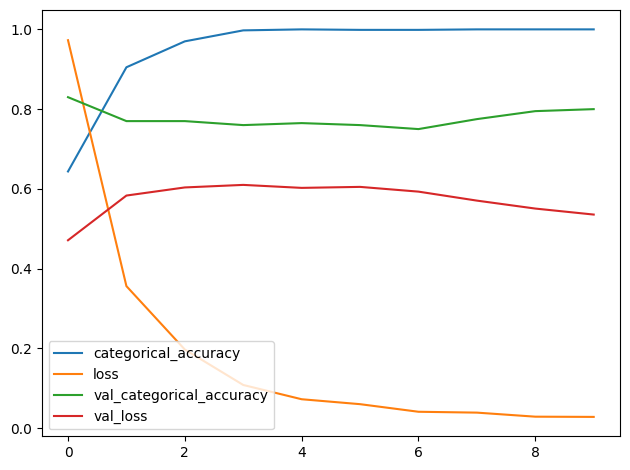

In [18]:
history = model.fit(
    train_x_resized,
    train_y,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[model_checkpoint_callback])

show_history(history)

In [19]:
# Load best setup
model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x_resized, test_y)
print('Test accuracy: ', test_acc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - categorical_accuracy: 0.8083 - loss: 0.5668
Test accuracy:  0.8180000185966492


## Now you are an absolute expert in CNN applications in the image classification tasks 👏

## We can switch to time series processing part of the lecture! 🙂

- 🔎What tasks can you imagine for time series processing?
- We will use CNN again, but now in Conv1D variant
  - 🔎 What is the difference among the 1 - 3D Conv?

### There is definitely a cool mathematical expression for each conv layer type however I would like you to understand the topic so we will use the diagrams below 🙂

![Meme02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_tf_02.png?raw=true)

### 📒 Conv2D

- Conv2D is generally used on Image data.
- It is called 2 dimensional CNN because the kernel slides along 2 dimensions on
  the data as shown in the following image.

![Conv2D](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_04_conv2d.png?raw=true)

### 📒 Conv1D

- Following plot illustrate how the kernel will move on accelerometer data.
- Each row represents time series acceleration for some axis.
  - The kernel can only move in one dimension along the axis of time.

![Conv1D](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_04_conv1d.png?raw=true)

# 📌 Summary

- In 1D CNN, kernel moves in 1 direction. Input and output data of 1D CNN is 2
  dimensional. Mostly used on Time-Series data.
- In 2D CNN, kernel moves in 2 directions. Input and output data of 2D CNN is 3
  dimensional. Mostly used on Image data.
- In 3D CNN, kernel moves in 3 directions. Input and output data of 3D CNN is 4
  dimensional. Mostly used on 3D Image data (MRI, Video).
  - 💡 You can check
    https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610
    for more details


# Download the FordA data

- Let's download
  [FordA](https://www.timeseriesclassification.com/description.php?Dataset=FordA)
  dataset converted for our purposes to the
  [Feather file format](https://arrow.apache.org/docs/python/feather.html), a
  binary file format for data exchange.

- 💡 The classification problem is to diagnose whether a certain symptom exists
  or does not exist in an automotive subsystem.

  - Each case consists of 500 measurements of engine noise and a classification.

- 💡 The data originates from ARFF file format used in Weka Data analysis tool
  and has classes labeled $\{-1,1\}$
  - We will convert it to the $\{0,1\}$ set


In [20]:
train = pd.read_feather(
    'https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/FordA_TRAIN.feather')
test = pd.read_feather('https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/FordA_TEST.feather')
train.target.replace({-1: 0}, inplace=True)
test.target.replace({-1: 0}, inplace=True)
print('Train: ', train.shape)
print('Test: ', test.shape)

Train:  (3601, 501)
Test:  (1320, 501)


/tmp/ipykernel_38450/642225585.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train.target.replace({-1: 0}, inplace=True)
/tmp/ipykernel_38450/642225585.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

## ⚡ We can take a look at the data

- The data contain 500 time steps of a measurement and single target value.
- The time series is almost normalized and it is not necessary to deal with it
  using scaling or normalizing.
  - It may slightly improve the results but it depends on your experiments.

### 🔎 What would you do if the time-series was continual sequence?

- How to preprocesss such data and feed it into ANN?


/tmp/ipykernel_38450/1427065118.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(train.iloc[idx][:-1], c=colors[int(train.iloc[idx][-1])])


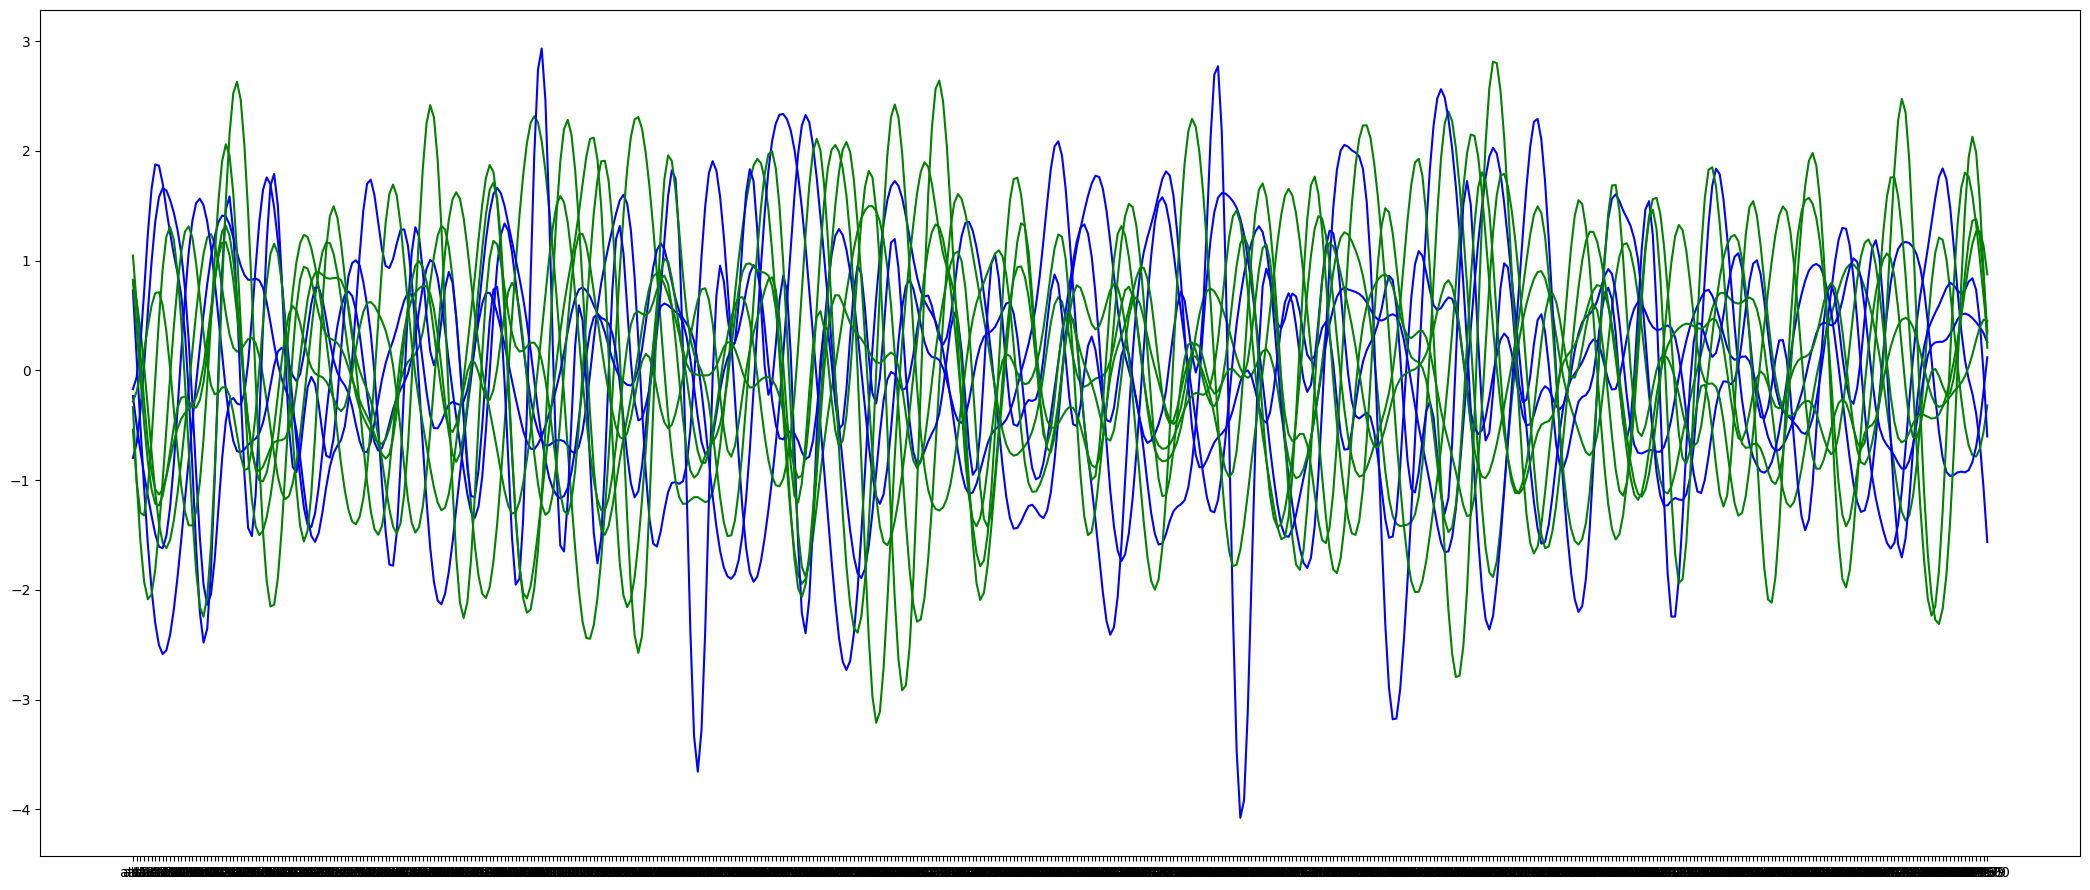

In [21]:
colors = ['b', 'g']
plt.figure(figsize=(21, 9))
for idx in range(10):
    plt.plot(train.iloc[idx][:-1], c=colors[int(train.iloc[idx][-1])])
plt.tight_layout()
plt.show()

In [22]:
train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att492,att493,att494,att495,att496,att497,att498,att499,att500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,0
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,1
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,0
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,0
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,0


In [23]:
train.groupby('target').mean()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
0,-0.014895,-0.015515,-0.016355,-0.016704,-0.015422,-0.011477,-0.006306,-0.001435,0.002810,0.004730,...,0.020576,0.014972,0.006110,-0.003215,-0.010949,-0.014388,-0.012541,-0.006267,0.002245,0.010434
1,-0.018616,-0.015013,-0.010712,-0.006936,-0.004227,-0.002419,-0.000538,0.002675,0.008029,0.015609,...,-0.003742,-0.001601,0.001889,0.005288,0.007573,0.008220,0.006549,0.002857,-0.002297,-0.008113


In [24]:
train.groupby('target').std()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
0,1.046503,1.038535,1.030145,1.031180,1.041815,1.051984,1.053741,1.048960,1.042726,1.03680,...,1.037209,1.037731,1.034531,1.025603,1.011854,0.997298,0.987655,0.990511,1.007039,1.028501
1,1.071179,1.066081,1.059798,1.054695,1.052556,1.053998,1.057515,1.060192,1.058752,1.05203,...,1.038403,1.043903,1.047698,1.048433,1.045641,1.040933,1.036925,1.035120,1.035589,1.036879


([], [])

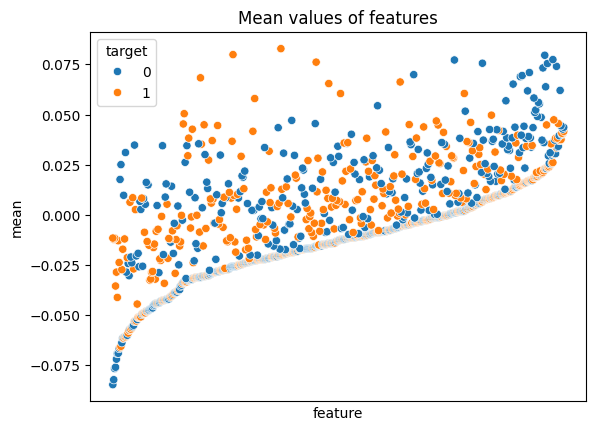

In [25]:
train.groupby('target').mean().stack().reset_index(
    name='mean').rename(
    columns={
        'level_1': 'feature'}).sort_values('mean')
sns.scatterplot(
    data=train.groupby('target').mean().stack().reset_index(
        name='mean').rename(
        columns={
            'level_1': 'feature'}).sort_values('mean'),
    y='mean',
    x='feature',
    hue='target').set_title('Mean values of features')
plt.xticks([])

# Check the labels balance

- 🔎 Which metrics can we use? Why?


In [26]:
train.target.value_counts()

target
0    1846
1    1755
Name: count, dtype: int64

# Convert the data into numpy arrays and separates _X_ and _y_ data from each other for training and testing data.


In [27]:
train_x, train_y = train.drop(columns=['target']).values, train.target.values
test_x, test_y = test.drop(columns=['target']).values, test.target.values

## ⚡ Create a baseline model

- Lets try some simple basic model on the data. DecisionTree and RandomForrest.
  - As you will see it is a difficult task for them to get high accuracy
    results.


In [28]:
base_models = [DecisionTreeClassifier(random_state=13), RandomForestClassifier(random_state=13)]

for model in base_models:
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print(type(model).__name__)
    compute_metrics(test_y, y_pred)

DecisionTreeClassifier
	Accuracy:    56.36%
RandomForestClassifier
	Accuracy:    73.18%


## Fully connected ANN model

- Let's try some basic neural network model for this task.
  - It is a typical Dense network with two hidden layers and dropout
    optimization - it should be able to beat the Randomforrest classifier.


In [29]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=train_x[0].shape),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(
        from_logits=False),
    metrics=[
        keras.metrics.BinaryAccuracy()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,561 (822.50 KB)

 Trainable params: 210,561 (822.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - binary_accuracy: 0.6024 - loss: 0.6745 - val_binary_accuracy: 0.6810 - val_loss: 0.5854
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7595 - loss: 0.5116 - val_binary_accuracy: 0.6976 - val_loss: 0.5712
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8181 - loss: 0.4325 - val_binary_accuracy: 0.7143 - val_loss: 0.5645
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8302 - loss: 0.3926 - val_binary_accuracy: 0.7240 - val_loss: 0.5605
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8665 - loss: 0.3189 - val_binary_accuracy: 0.7406 - val_loss: 0.5387
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.8645 - loss: 0.3109 - val_binary_accuracy: 0.7393 - val_loss: 0.5729
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9047 - loss: 0.2488 - val_binary_accuracy: 0.7434 - val_loss: 0.5604
Epoch 8/10
90/90 ━━

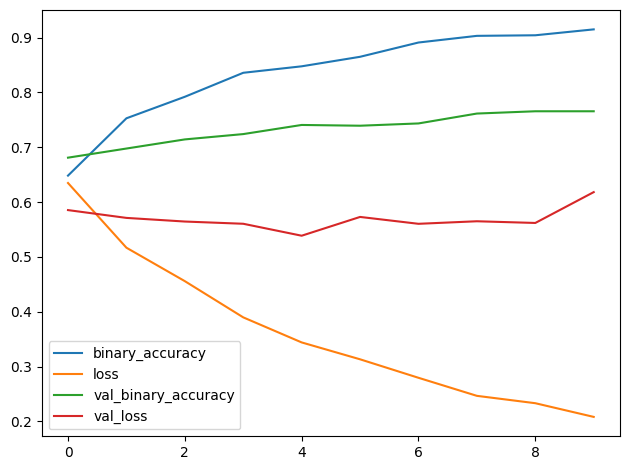

In [31]:
history = model.fit(train_x, train_y, validation_split=0.2, epochs=10,
                    batch_size=32, callbacks=[model_checkpoint_callback])
show_history(history)

model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

# 🚀 Now we will finally use the CNN! 🙂

- To use convolution in single dimension we need to reshape the data to have the
  proper format.
  - The format is the same as for RNN and must be in a format
    $(number\_of\_vectors, vector\_length,number\_of\_dimensions)$
    - Given the user experience for the time series analysis tasks in
      Tensorflow, sharing the same input format between CNN and RNN must've been
      an accident 😅


In [32]:
train_xc = np.reshape(train_x, (*train_x.shape, 1))
test_xc = np.reshape(test_x, (*test_x.shape, 1))
train_xc.shape, test_xc.shape

((3601, 500, 1), (1320, 500, 1))

## Let's try the single convolution layer as a input mapping

- It generates a huge number of weights for Dense layers after flattening

- The results are far from excelent
  - 🔎 Why?


In [33]:
model = keras.Sequential([
    keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=train_xc[0].shape),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(
        from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 498, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 31872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │     2,039,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,040,193 (7.78 MB)

 Trainable params: 2,040,193 (7.78 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - binary_accuracy: 0.5684 - loss: 0.7227 - val_binary_accuracy: 0.6352 - val_loss: 0.6606
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7397 - loss: 0.5432 - val_binary_accuracy: 0.7074 - val_loss: 0.5870
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7950 - loss: 0.4552 - val_binary_accuracy: 0.7379 - val_loss: 0.5425
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8601 - loss: 0.3523 - val_binary_accuracy: 0.7240 - val_loss: 0.5785
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9033 - loss: 0.2716 - val_binary_accuracy: 0.7295 - val_loss: 0.5654
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9052 - loss: 0.2396 - val_binary_accuracy: 0.7545 - val_loss: 0.5625
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9356 - loss: 0.1879 - val_binary_accuracy: 0.7365 - val_loss: 0.6196
Epoch 8/10
90/90 ━━━━━━━━━━━━━

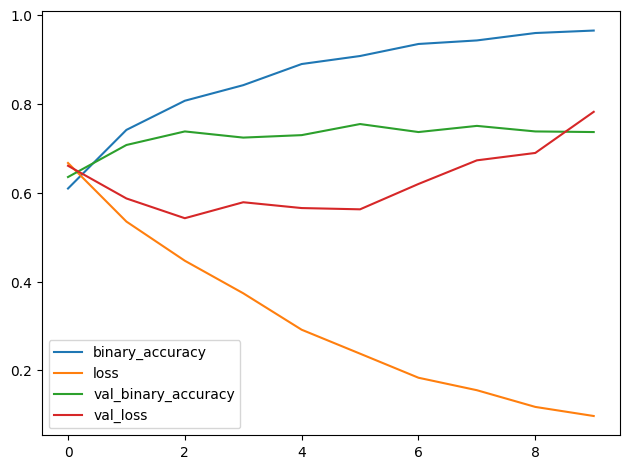

In [35]:
history = model.fit(train_x, train_y, validation_split=0.2, epochs=10,
                    batch_size=32, callbacks=[model_checkpoint_callback])
show_history(history)

model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## A slightly more complicated model is able to beat all previous models with smaller number of weights needed


In [36]:
model = keras.Sequential([
    keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=train_xc[0].shape),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy()])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 498, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 496, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 246, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 244, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │       999,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,036,865 (3.96 MB)

 Trainable params: 1,036,865 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - binary_accuracy: 0.5598 - loss: 0.6659 - val_binary_accuracy: 0.6935 - val_loss: 0.5279
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.7498 - loss: 0.4626 - val_binary_accuracy: 0.8294 - val_loss: 0.3501
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8705 - loss: 0.2920 - val_binary_accuracy: 0.8308 - val_loss: 0.3871
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9172 - loss: 0.2065 - val_binary_accuracy: 0.8183 - val_loss: 0.3799
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9014 - loss: 0.2368 - val_binary_accuracy: 0.8710 - val_loss: 0.2932
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9605 - loss: 0.1005 - val_binary_accuracy: 0.8474 - val_loss: 0.3582
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9721 - loss: 0.0782 - val_binary_accuracy: 0.8460 - val_loss: 0.4910
Epoch 8/10
90/90 ━━

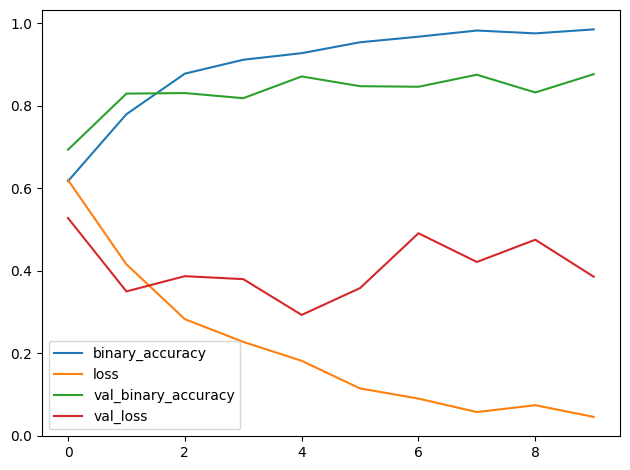

In [38]:
history = model.fit(train_x, train_y, validation_split=0.2, epochs=10,
                    batch_size=32, callbacks=[model_checkpoint_callback])
show_history(history)

model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## Even more capable model with more pooling layers but with 1/4 weight of the previsou model is able to achieve more than 90% of the accuracy


In [39]:
model = keras.Sequential([
    keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=train_xc[0].shape),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(
        from_logits=False),
    metrics=[
        keras.metrics.BinaryAccuracy()])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 498, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 249, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 247, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 123, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 121, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 58, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3712)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       237,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,009 (1.05 MB)

 Trainable params: 275,009 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - binary_accuracy: 0.5522 - loss: 0.6669 - val_binary_accuracy: 0.8322 - val_loss: 0.3946
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8422 - loss: 0.3540 - val_binary_accuracy: 0.8904 - val_loss: 0.2946
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9081 - loss: 0.2286 - val_binary_accuracy: 0.8752 - val_loss: 0.3184
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9072 - loss: 0.2166 - val_binary_accuracy: 0.9154 - val_loss: 0.2296
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9351 - loss: 0.1576 - val_binary_accuracy: 0.9126 - val_loss: 0.2255
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9478 - loss: 0.1426 - val_binary_accuracy: 0.9043 - val_loss: 0.2538
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9559 - loss: 0.1055 - val_binary_accuracy: 0.8946 - val_loss: 0.2888
Epoch 8/10
90/90 ━━

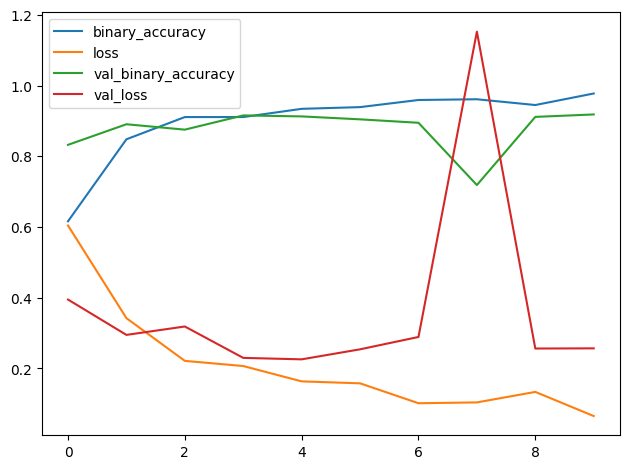

In [41]:
history = model.fit(train_x,
                    train_y,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32,
                    callbacks=[model_checkpoint_callback])
show_history(history)

model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

# ✅ Tasks for the lecture (2p)

1. Choose any of the models from
   [Keras pre-trained models](https://keras.io/api/applications/) - **(1p)**

   - Investigate its' architecture
   - Search for the needed input shape for the model - remeber to preprocess the
     data and call correct `preprocess_input` function
     - 💡 There could be more variants of the model, the choice depends on you
   - Use the selected model for CIFAR-10 classification,
     - Fine-tune it, experiment with it and write down your conclusions!

2. Define your own model for the FordA data task - **(1p)**

   - Try to beat defined models or have at least the same accuracy score
     - 💡 You can also try to minimize the number of parameters for having
       approx. the same accuracy as we do!
   - Experiment with the model and write down your conclusions!


# Tasks


## Task 1


### Load and preprocess the CIFAR-10 dataset


In [42]:
dataset = tf.keras.datasets.cifar10
img_size = 224
subset = 1000
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)

In [43]:
(train_x, train_y), (test_x, test_y) = dataset.load_data()
train_y = to_categorical(train_y[:subset], class_count)
test_y = to_categorical(test_y[:subset], class_count)
train_x_resized = tf.image.resize(train_x[:subset], [img_size, img_size])
test_x_resized = tf.image.resize(test_x[:subset], [img_size, img_size])

### ⚙️🚀 Instantiate an EfficientNet Model with Pre-trained Weights


In [44]:
base_model = EfficientNetB7(weights='imagenet', input_shape=(img_size, img_size, 3), include_top=False)
base_model.trainable = False

#### 🆕 Added Layers in EfficientNet

1. **Input** 📥:  
   - **Input(shape=(img_size, img_size, 3))**

2. **Preprocessing** 🔄:  
   - **preprocess_input(inputs)**

3. **Base Model** 🏗️:  
   - **base_model(x, training=False)**

4. **Global Average Pooling** 🌍📉:  
   - **GlobalAveragePooling2D()**

5. **Fully Connected Layers** ⚡:  
   - **Dense(512, relu)** 🧠, **Dropout(0.5)** 🎲  
   - **Dense(256, relu)** 🧠, **Dropout(0.5)** 🎲  
   - **Dense(128, relu)** 🧠, **Dropout(0.5)** 🎲

6. **Output** 🎯:  
   - **Dense(class_count, softmax)** 📊


In [45]:
inputs = Input(shape=(img_size, img_size, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs, outputs)

### 🛠️⚡ Compile the model


In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [47]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

### 🚆📈 Train the model


In [48]:
history = model.fit(
    train_x_resized,
    train_y,
    epochs=25,
    batch_size=32,
    validation_data=(
        test_x_resized,
        test_y),
    callbacks=[model_checkpoint_callback])

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - categorical_accuracy: 0.2229 - loss: 2.1536 - val_categorical_accuracy: 0.8330 - val_loss: 0.7883
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 488ms/step - categorical_accuracy: 0.6650 - loss: 1.0282 - val_categorical_accuracy: 0.8800 - val_loss: 0.4116
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 524ms/step - categorical_accuracy: 0.8205 - loss: 0.6054 - val_categorical_accuracy: 0.8770 - val_loss: 0.3906
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 506ms/step - categorical_accuracy: 0.8434 - loss: 0.5102 - val_categorical_accuracy: 0.8980 - val_loss: 0.3730
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 487ms/step - categorical_accuracy: 0.8860 - loss: 0.3675 - val_categorical_accuracy: 0.8950 - val_loss: 0.3748
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 515ms/step - categorical_accuracy: 0.9076 - loss: 0.2702 - val_categorical_accuracy: 0.8970 - val_loss: 0.3721
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 505ms/step - categorical_accuracy: 0.9350 

### 📊🔍 Show the results


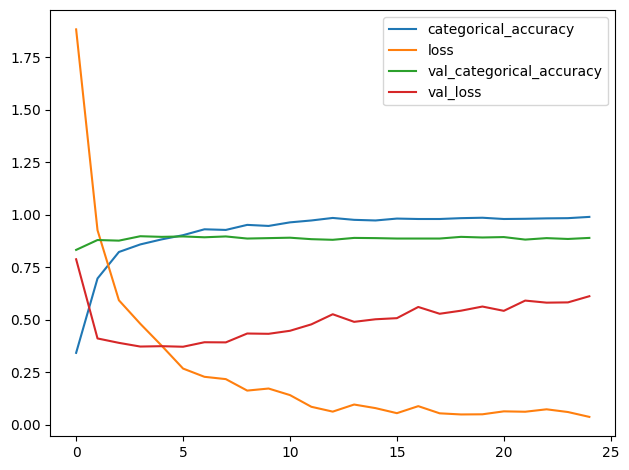

In [49]:
show_history(history)

#### 📥🧪 Load the model and test it


In [50]:
model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x_resized, test_y)
print('Test accuracy: ', test_acc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - categorical_accuracy: 0.8935 - loss: 0.3858
Test accuracy:  0.8970000147819519


## Task 2


### 📥🚗 Load and preprocess the FordA dataset


In [51]:
train = pd.read_feather(
    'https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/FordA_TRAIN.feather')
test = pd.read_feather('https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/FordA_TEST.feather')

train.loc[:, "target"] = train["target"].replace({-1: 0})
test.loc[:, "target"] = test["target"].replace({-1: 0})

In [52]:
train_x, train_y = train.drop(columns=['target']).values, train.target.values
test_x, test_y = test.drop(columns=['target']).values, test.target.values

In [53]:
train_xc = np.reshape(train_x, (*train_x.shape, 1))
test_xc = np.reshape(test_x, (*test_x.shape, 1))

### 📝⚙️ Define the model


#### 🧠 Model Summary

1. **Conv1D + BatchNormalization + MaxPool + Dropout (Block 1)**

   - **Conv1D(128)** 🔍💡: 1D convolution with 128 filters.
   - **BatchNormalization()** ⚖️: Normalizes output.
   - **MaxPool1D(2)** 🔽: Reduces dimensions.
   - **Dropout(0.3)** 🎲🚫: Regularization.

2. **Conv1D + BatchNormalization + MaxPool + Dropout (Block 2)**

   - **Conv1D(256)** 🔍💡: 1D convolution with 256 filters.
   - **BatchNormalization()** ⚖️: Normalizes output.
   - **MaxPool1D(2)** 🔽: Further reduces dimensions.
   - **Dropout(0.3)** 🎲🚫: Regularization.

3. **Conv1D + BatchNormalization + MaxPool + Dropout (Block 3)**

   - **Conv1D(512)** 🔍💡: 1D convolution with 512 filters.
   - **BatchNormalization()** ⚖️: Normalizes output.
   - **MaxPool1D(2)** 🔽: Further pooling.
   - **Dropout(0.3)** 🎲🚫: Regularization.

4. **Fully Connected Layers**
   - **Flatten()** 🛠️: Flattens output for dense layers.
   - **Dense(256, relu)** 🧠⚡: Fully connected with 256 neurons.
   - **Dropout(0.3)** 🎲🚫: Regularization.
   - **Dense(1, sigmoid)** 🎯🔒: Output layer for binary classification.


In [54]:
model = keras.Sequential([
    keras.layers.Conv1D(128, kernel_size=5, activation='relu', input_shape=train_xc[0].shape),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv1D(256, kernel_size=5, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv1D(512, kernel_size=5, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool1D(2),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 496, 128)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 496, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 248, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 248, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 244, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 244, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 122, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 122, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 118, 512)       │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 118, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 59, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 59, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     7,733,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,558,081 (32.65 MB)

 Trainable params: 8,556,289 (32.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

### 🛠️⚡ Compile the model


In [55]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy()])

In [56]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True
)

### 🚆📈 Train the model


In [57]:
history = model.fit(
    train_xc,
    train_y,
    validation_split=0.2,
    epochs=25,
    batch_size=32,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - binary_accuracy: 0.6319 - loss: 1.5639 - val_binary_accuracy: 0.4743 - val_loss: 0.7060
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.8689 - loss: 0.3070 - val_binary_accuracy: 0.4743 - val_loss: 1.9292
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - binary_accuracy: 0.9077 - loss: 0.2180 - val_binary_accuracy: 0.4743 - val_loss: 2.1132
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - binary_accuracy: 0.9204 - loss: 0.1909 - val_binary_accuracy: 0.4854 - val_loss: 2.4496
Epoch 5/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.9352 - loss: 0.1678 - val_binary_accuracy: 0.5908 - val_loss: 1.0955
Epoch 6/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - binary_accuracy: 0.9401 - loss: 0.1471 - val_binary_accuracy: 0.8003 - val_loss: 0.5354
Epoch 7/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - binary_accuracy: 0.9413 - loss: 0.1399 - val_binary_accuracy: 0.8558 - val_loss: 0.3735
Epoch 8/25
9

### 📊🔍 Show the results


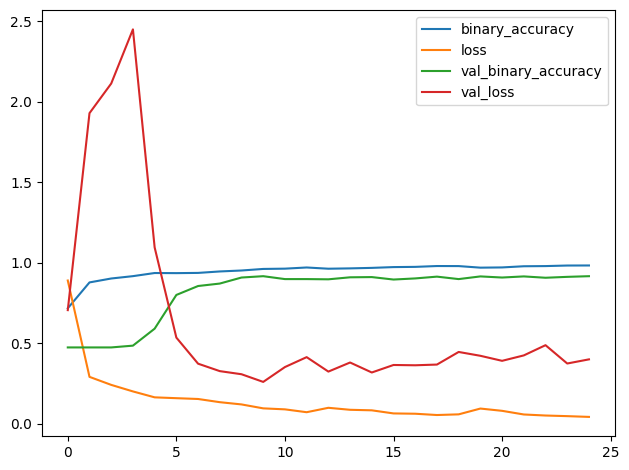

In [58]:
show_history(history)

### 🧪🔍 Test the model


In [59]:
model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_xc, test_y)
print('Test accuracy: ', test_acc)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - binary_accuracy: 0.9373 - loss: 0.1778
Test accuracy:  0.9204545617103577
